In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
with open('../python/methods.py', 'r') as file:
    exec(file.read())

with open('../python/methods_for_r.py', 'r') as file:
    exec(file.read())

In [66]:
samples = pd.read_csv('../sample_sheet.csv')

In [82]:
movement = []
no_movement = []
filtered = []
for index, sample in samples.iterrows():
    animal_id = sample['AnimalID']
    cell_name = sample['CellName']
    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'
    dt = pd.read_pickle(f'{prefix}/emg/movement_events.pkl')
    dt['AnimalID'] = animal_id
    dt['CellName'] = cell_name
    dt['SID'] = sample['SID']
    dt['Region'] = sample['Region']
    dt['EventID'] = [f'Event{x}' for x in range(len(dt))]
    movement.append(dt)
    dt = pd.read_pickle(f'{prefix}/emg/no_movement_events.pkl')
    dt['AnimalID'] = animal_id
    dt['CellName'] = cell_name
    dt['SID'] = sample['SID']
    dt['Region'] = sample['Region']
    dt['EventID'] = [f'Event{x}' for x in range(len(dt))]
    no_movement.append(dt)
    dt = pd.read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')
    dt['AnimalID'] = animal_id
    dt['CellName'] = cell_name
    dt['SID'] = sample['SID']
    dt['Region'] = sample['Region']
    dt['EventID'] = [f'Event{x}' for x in range(len(dt))]
    filtered.append(dt)

movement = pd.concat(movement, ignore_index = True)
no_movement = pd.concat(no_movement, ignore_index = True)
filtered = pd.concat(filtered, ignore_index = True)

In [83]:
len(movement)

2003

In [84]:
len(no_movement)

2211

In [86]:
len(filtered)

1008

In [88]:
no_movement.to_csv('../figures/no_movement_info.csv')
filtered.to_csv('../figures/movement_info.csv')

In [99]:
final_data = []
for index, sample in samples.iterrows():
    print(f'Processing sample {sample["SID"]}')
    animal_id = sample['AnimalID']
    cell_name = sample['CellName']
    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'

    sample_data = pd.read_pickle(f'{prefix}/vm/filter.pkl')

    sample_events = pd.read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')
    event_data = []
    for i, event in sample_events.iterrows():
        start = event['Start']
        end = event['End']
        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end)

        event_data.append(pd.DataFrame({
            'EventID': i,
            'Time': channel_data.times,
            'Vm': channel_data.get_data(picks = [channel]).flatten(),
            'Region': sample['Region'],
            'SID': sample['SID'],
            'Type': 'Movement'
        }))

    final_data.append(pd.concat(event_data))

    sample_events = pd.read_pickle(f'{prefix}/emg/no_movement_events.pkl')
    event_data = []
    for i, event in sample_events.iterrows():
        start = event['Start']
        end = event['End']
        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end)

        event_data.append(pd.DataFrame({
            'EventID': i,
            'Time': channel_data.times,
            'Vm': channel_data.get_data(picks = [channel]).flatten(),
            'Region': sample['Region'],
            'SID': sample['SID'],
            'Type': 'No movement'
        }))

    final_data.append(pd.concat(event_data))

Processing sample W1_C1
Processing sample W1_C2
Processing sample W1_C8
Processing sample W2_C3
Processing sample W2_C4
Processing sample W2_C5
Processing sample W2_C6
Processing sample W3_C10
Processing sample W3_C11
Processing sample W4_C10
Processing sample W3_C12
Processing sample W3_C13
Processing sample W3_C14
Processing sample W3_C15
Processing sample W3_C16
Processing sample W4_C11
Processing sample W4_C12
Processing sample W4_C13
Processing sample W4_C14
Processing sample W4_C15
Processing sample W1_C3
Processing sample W1_C4
Processing sample W1_C5
Processing sample W1_C6
Processing sample W2_C1
Processing sample W2_C2
Processing sample W3_C1
Processing sample W3_C2
Processing sample W3_C3
Processing sample W3_C7
Processing sample W4_C1
Processing sample W4_C2
Processing sample W2_C7
Processing sample W3_C4
Processing sample W3_C5
Processing sample W3_C6
Processing sample W3_C8
Processing sample W4_C3
Processing sample W4_C4
Processing sample W4_C5
Processing sample W4_C7
Pro

In [100]:
final_data = pd.concat(final_data, ignore_index = True)

In [101]:
final_data.to_csv('../figures/vm_data.csv')

In [104]:
def find_ap(signal, time, ap_threshold = -10):
    over_threshold = np.where(signal > ap_threshold)[0]

    if len(over_threshold) == 0:
        return []

    idx_diff = np.where(np.diff(over_threshold) != 1)[0]
    ap_count = np.append(over_threshold[0], over_threshold[idx_diff + 1])

    return time[ap_count]

In [142]:
ap_data = []

for index, sample in samples.iterrows():
    print(f'Processing sample {sample["SID"]}')
    animal_id = sample['AnimalID']
    cell_name = sample['CellName']
    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'

    sample_data = pd.read_pickle(f'{prefix}/vm/filter.pkl')

    sample_events = pd.read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')
    event_data = []
    for i, event in sample_events.iterrows():
        start = event['Start']
        end = event['End']
        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end)

        event_data.append(pd.DataFrame({
            'EventID': [i],
            'CountAP': len(
                find_ap(channel_data.get_data(picks = [channel]).flatten(), channel_data.times, ap_threshold = -20)),
            'Region': sample['Region'],
            'SID': sample['SID'],
            'Type': 'Movement'
        }))

    ap_data.append(pd.concat(event_data))

    sample_events = pd.read_pickle(f'{prefix}/emg/no_movement_events.pkl')
    event_data = []
    for i, event in sample_events.iterrows():
        start = event['Start']
        end = event['End']
        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end)

        event_data.append(pd.DataFrame({
            'EventID': [i],
            'CountAP': len(
                find_ap(channel_data.get_data(picks = [channel]).flatten(), channel_data.times, ap_threshold = -20)),
            'Region': sample['Region'],
            'SID': sample['SID'],
            'Type': 'No movement'
        }))

    ap_data.append(pd.concat(event_data))

Processing sample W1_C1
Processing sample W1_C2
Processing sample W1_C8
Processing sample W2_C3
Processing sample W2_C4
Processing sample W2_C5
Processing sample W2_C6
Processing sample W3_C10
Processing sample W3_C11
Processing sample W4_C10
Processing sample W3_C12
Processing sample W3_C13
Processing sample W3_C14
Processing sample W3_C15
Processing sample W3_C16
Processing sample W4_C11
Processing sample W4_C12
Processing sample W4_C13
Processing sample W4_C14
Processing sample W4_C15
Processing sample W1_C3
Processing sample W1_C4
Processing sample W1_C5
Processing sample W1_C6
Processing sample W2_C1
Processing sample W2_C2
Processing sample W3_C1
Processing sample W3_C2
Processing sample W3_C3
Processing sample W3_C7
Processing sample W4_C1
Processing sample W4_C2
Processing sample W2_C7
Processing sample W3_C4
Processing sample W3_C5
Processing sample W3_C6
Processing sample W3_C8
Processing sample W4_C3
Processing sample W4_C4
Processing sample W4_C5
Processing sample W4_C7
Pro

In [143]:
ap_data = pd.concat(ap_data, ignore_index = True)

In [149]:
ap_data.to_csv('../figures/ap_data.csv')

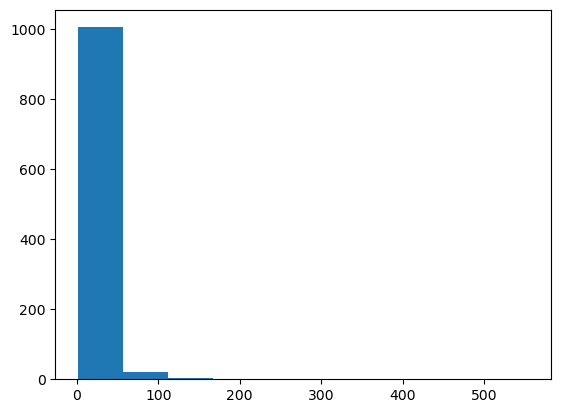

In [148]:
plt.hist(ap_data[ap_data['CountAP'] != 0]['CountAP'])
plt.show()

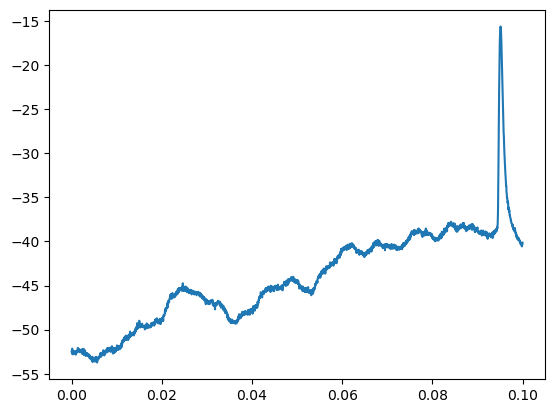

In [111]:
plt.plot(channel_data.copy().crop(tmin = 0, tmax = 0.1).times,
         channel_data.copy().crop(tmin = 0, tmax = 0.1).get_data(picks = [channel]).flatten())